### Imports

In [1]:
import re
import glob
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

### Function definitions
##### rle_to_binary() decodes the run length encoded mask into a binary mask

In [2]:
def rle_to_binary(rle, shape): 
    
    # create array of zeros representing a blank mask
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # split rle string into list
    s = rle.split()
    
    # convert the starts and lengths to numpy arrays of integers
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])] 
    
    # subtract 1 from the starts since RLE encoding is 1-index and python uses 0-indexing
    starts -= 1
    
    # calculate the end positions of each continuous sequence by adding the lengths to their respective starts (ends = starts + lengths)
    for start, length in zip(starts, lengths):
        mask[start:start+length] = 1
      
    # reshape the 1D array to the desired 2D output shape
    return mask.reshape(shape, order='F')

##### create_multiclass_mask() decodes each mask for each of the three classes and stacks them into a single multi-channel array

In [3]:
def create_multiclass_mask(rle_list, original_shape, target_shape):
    
    masks = []
    
    for rle in rle_list:
        # decode he rle mask into a binary mask
        mask = rle_to_binary(rle, original_shape)
        
        # reshape the mask to so that it matches the target
        resized = resize(mask, target_shape, preserve_range=True, mode='reflect', anti_aliasing=True)
        masks.append(resized)
        
    return np.stack(masks, axis=-1)

#### custom_datagen() creates a custom image data generator that can simultaneously preprocess each image alongside its target masks

In [4]:
def custom_datagen(gdf, dir, batch_size, target_size):
    
    # create the image data generator, for now only normalizing as a preprocessing step
    datagen = ImageDataGenerator(rescale=1/255)
    
    # create a list of unique image ids
    ids = list(gdf.groups.keys())
    
    while True:
            
        sample_ids = np.random.choice(ids, size=batch_size, replace=False)
            
        images = []
        masks = []
        
        for id in sample_ids:
            # get the dataframe rows for the current image
            img_rows = gdf.get_group(id)
            
            # extract the rle masks from the rows
            rle_list = img_rows['segmentation'].tolist()
            
            # search the dataset directory for an image matching the image id
            sections = id.split('_')
            case = sections[0]
            day = sections[0] + '_' + sections[1]
            slice = sections[2] + '_' + sections[3]
            
            pattern = os.path.join(dir, case, day, "scans", f"{slice}*.png")
            file = glob.glob(pattern)[0]
                        
            # load the image and correct its size 
            original_shape = Image.open(file).size[::-1]
            image = load_img(file, target_size=target_size, color_mode='grayscale')
            image_array = img_to_array(image)
            
            # load and decode the multiclass mask and resize it accordingly
            mask = create_multiclass_mask(rle_list, original_shape, target_size)
            
            images.append(image_array)
            masks.append(mask)
            
        x = np.array(images)
        y = np.array(masks)
                
        # yield statement allows us to return some data to the caller and if
        # called again resume execution from within the while loop
        yield next(datagen.flow(x, y, batch_size=batch_size))


#### make_unet() builds the U-Net architecture and returns the model. It consists of an encoder of contracting convolutional layers, a bottleneck, and a decoder which upsamples and concatenates previous layers. The output layer is softmax since we are classifying every pixel in the image. Within this framework we can add and subtract layers as well as experiment with different activation functions.

In [5]:
def make_unet(input_size, num_classes=3):
    
    input = Input(input_size)
    
    # contracting
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # bottleneck
    convB = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    convB = Conv2D(256, (3, 3), activation='relu', padding='same')(convB)
    
    # expanding
    up3 = concatenate([UpSampling2D(size=(2, 2))(convB), conv2], axis=-1)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    
    # concatenate operations on the expanding section combine feature maps from earlier layers
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv1], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv4)
    
    return Model(inputs=input, outputs=output)

In [6]:
# read the csv file into a dataframe and convert it into a groupby object to keep our images grouped by id
df = pd.read_csv('./Dataset/train.csv')
df['segmentation'] = df['segmentation'].fillna('0')

grouped_df = df.groupby('id')

# dataset directory
dir = '.\\Dataset\\train'

batch_size = 32
target_size = 256

# steps per epoch is typically train_length / batch_size to use all data points
steps_per_epoch = math.ceil(len(df) / batch_size)

# create the training data generator
train_generator = custom_datagen(grouped_df, dir, batch_size, (target_size, target_size))

In [7]:
# create the U-net neural network and compile it
model = make_unet(input_size=(target_size, target_size, 1), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# for debugging purposes we'll pass 5 steps_per_epoch rather than our calculated value
model.fit(train_generator, steps_per_epoch=5, batch_size=batch_size, epochs=1)

5/5 [==============================] - 127s 25s/step - loss: 0.0337 - accuracy: 0.3974


#### Make sure the model's output is a correctly formatted binary mask

In [9]:
test_images = next(train_generator)

# softmax outputs probabilities which we must threshold to obtain predictions
preds = model.predict(test_images[0])

# threshold of 0.5 is temporary until we find the optimal threshold
threshold = 0.5
preds = (preds >= threshold).astype(int)

1/1 [==============================] - 5s 5s/step


In [32]:
preds[1]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [31]:
test_images[1][1].astype(int)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

#### Display images from the dataset with their true and predicted mask

In [35]:
# true masks
tmask_1 = test_images[1][1][:, :, 0]
tmask_2 = test_images[1][1][:, :, 1]
tmask_3 = test_images[1][1][:, :, 2]
tmasks = [tmask_1, tmask_2, tmask_3]

# predicted masks
pmask_1 = preds[1][:, :, 0]
pmask_2 = preds[1][:, :, 1]
pmask_3 = preds[1][:, :, 2]
pmasks = [pmask_1, pmask_2, pmask_3]

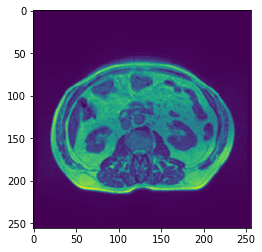

In [41]:
plt.imshow(test_images[0][1])

#### Top row are the true masks and bottom row are the predicted masks

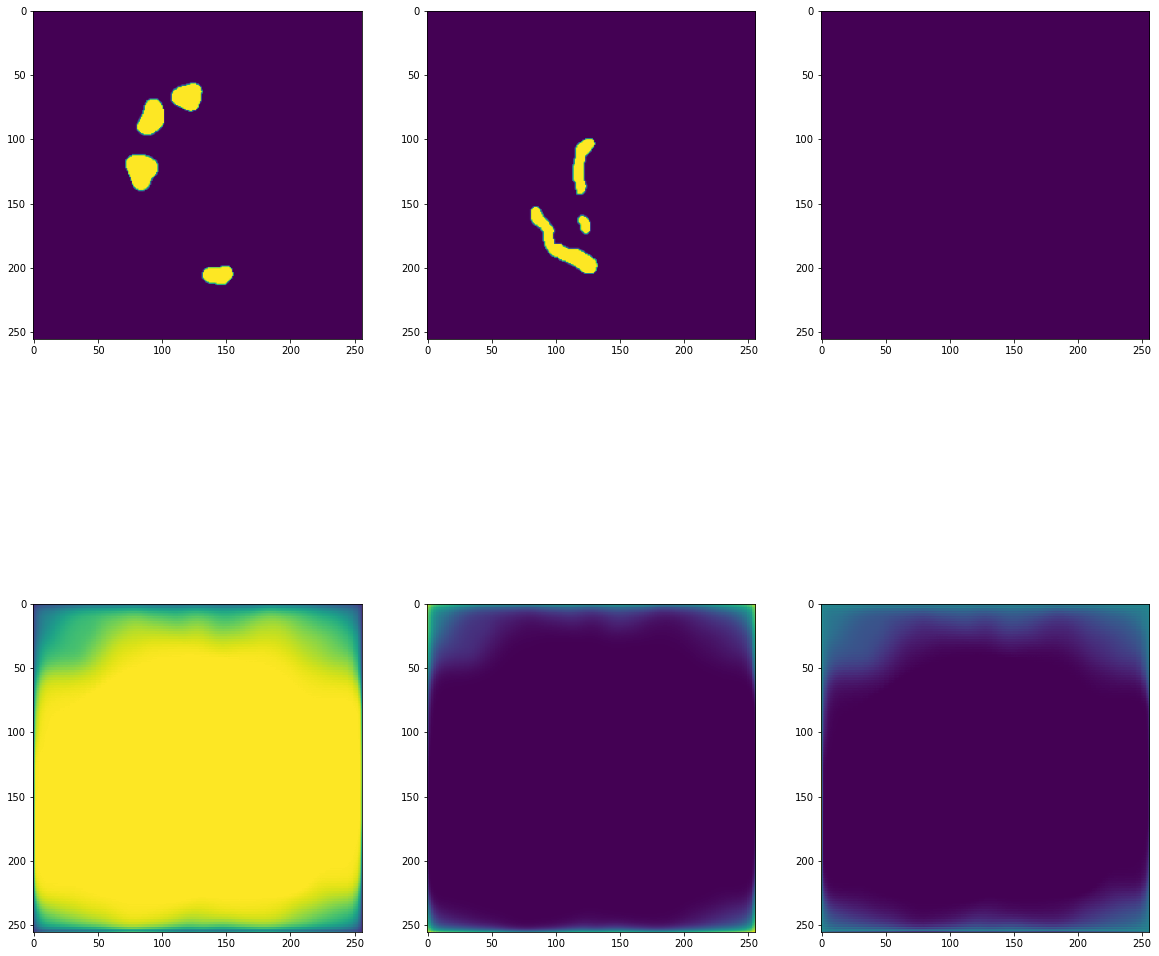

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))

for i in range(3):
    ax[0, i].imshow(tmasks[i])
    ax[1, i].imshow(pmasks[i])